In [73]:
# imports 
import numpy as np 
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Part I

## Generation of synthetic data

In [24]:
# Question 1
def get_signal():
    signal = open("signal.txt", "r")
    signal = signal.readlines()
    signal = [float(i.split("\n")[0]) for i in signal]
    return signal
signal = get_signal()

In [59]:
# Question 2
signal = np.array(signal)
N = len(signal)   # 200
T_min = 1
T_max = 1000
log = np.log(T_min / T_max)
T = np.array([T_min * 
              np.exp(
                  -(i - 1) * 
                  (log) / (N - 1)
                  ) 
                  for i in range(1, N + 1)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


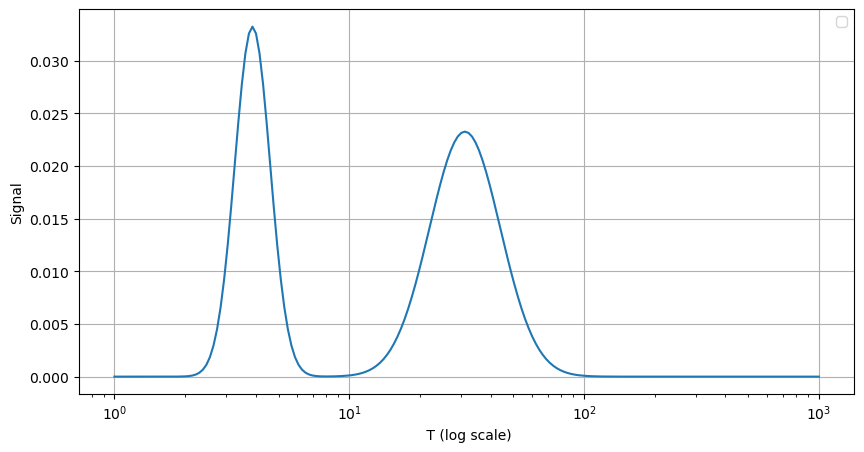

In [60]:
# Question 3 
plt.figure(figsize = (10, 5))
plt.plot(T, signal)
plt.xlabel(" T (log scale)")
plt.ylabel("Signal")    
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()

In [61]:
# Question 4
M = 50
t_min = 0
t_max = 1.5
m = np.arange(1, M + 1)
t_m = t_min + (m - 1) * (t_max - t_min) / (M - 1)

In [62]:
# Question 5
K = np.exp(- np.outer(t_m, T))

In [63]:
# Question 6 
z = np.dot(K, signal)
sigma = 0.01 * z[0]
w = np.random.multivariate_normal(np.zeros(M), (sigma ** 2) * np.eye(M))
y = z + w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


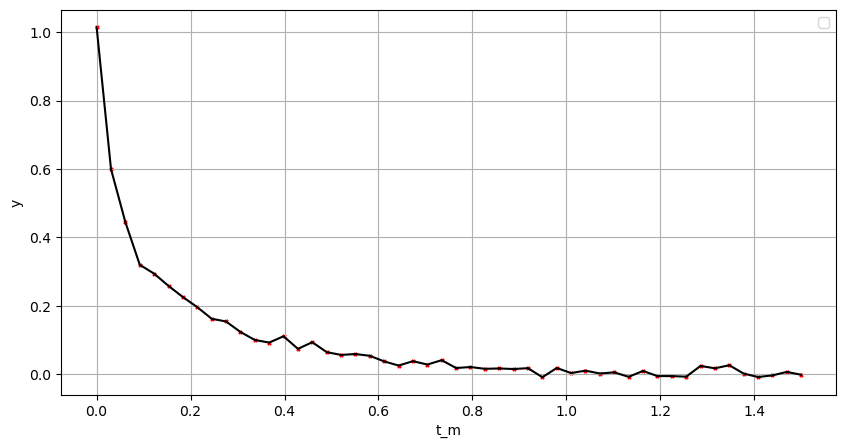

In [64]:
plt.figure(figsize = (10, 5))
plt.plot(t_m, y, color = "black")
plt.scatter(t_m, y, color = "red", s = 5, marker = "x")
plt.xlabel("t_m")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

$ \quad $

---

$ \quad $

## Comparison of regularization strategies

For every penalization functions $g$ listed at the end of the document,
1. Discuss the existence and uniqueness of a solution to
$$ \hat{x} = \text{arg}\min_{x \in \mathbb{R}^N} \frac{1}{2} \parallel Kx - y \parallel^2 + \beta g(x)$$
2. Propose an approach to solve the problem above.
3. Implement the approach and display the restored signal $\hat{x}$
4. Compute the normalized quadratic error between $\hat{x}$ and $\overline{x}$:
$$ E(\hat{x}, \overline{x}) = \frac{\parallel \hat{x} - \overline{x} \parallel^2}{\parallel \overline{x} \parallel^2}$$
5. When needed, search manually for the best choice for parameter $\beta$ in terms of reconstruction error.

---

### Smoothness prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2$$
where $D \in \mathbb{R}^{N \times N}$ is the discrete gradient operator defined such that:
$$\forall n \in \{1, \ldots, N \}, [Dx]^{(n)} = x^{(n)} - x^{(n-1)}$$
with the circular convention that $x^{(0)} = x^{(N)}$. The role of such regularization term is to promote the reconstruction of smooth signals.

---

### Smoothness prior + constraints


$$ \forall x \in \mathbb{R}^N, \quad g(x) = \frac{1}{2} \parallel Dx \parallel^2 + \iota_{[x_{ \text{min}}, x_{ \text{max}}]^N}(x) $$

with $0 < x_{ \text{min}} < x_{ \text{max}} $ the minimum and maximum values of the original signal $\overline{x}$.

---

#### Sparsity prior

$$\forall x \in \mathbb{R}^N, \quad g(x) = \parallel x \parallel_1$$

---

In [47]:
def quadratic_error(x_hat, x):
    """
    Compute the normalized quadratic error between the restored signal
    and the ground truth signal.
    """
    error = np.linalg.norm(x_hat - x, ord = 2) ** 2 / np.linalg.norm(x, ord = 2) ** 2 
    return error

Optimal beta: 0.7275454545454546


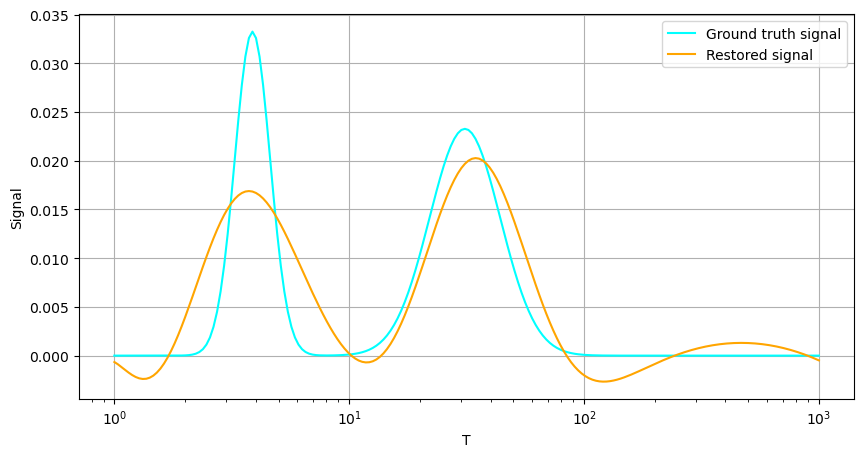

In [69]:
# smoothness prior 
D = np.eye(N) - np.eye(N, k = -1)
D[0, -1] = -1 

error = np.inf 
x_hat = None
beta = None

def Hessian(K, b, D):
    return np.dot(K.T, K) + b * np.dot(D.T, D)

for b in np.linspace(0.001, 1, num = 100):
    H = Hessian(K, b, D)
    x_hat_loop = np.linalg.inv(H).dot(K.T).dot(y)
    current_error = quadratic_error(x_hat_loop, signal)
    if current_error < error:
        error = current_error 
        beta = b
        x_hat = x_hat_loop

print(f"Optimal beta: {beta}")
plt.figure(figsize = (10, 5))
plt.plot(T, signal, label = "Ground truth signal", color = 'cyan')
plt.plot(T, x_hat, label = "Restored signal", color = 'orange')
plt.xlabel("T")
plt.ylabel("Signal")
plt.grid()
plt.legend()
plt.xscale("log")
plt.show()

100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


Optimal beta: 0.01


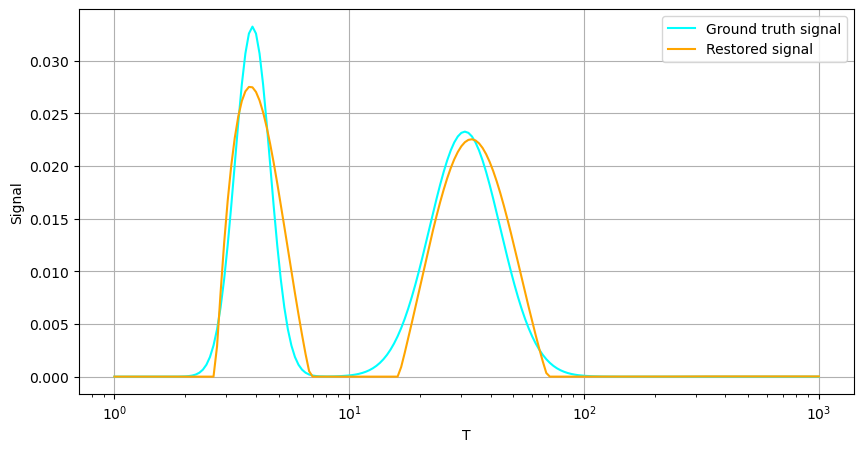

In [74]:
# smoothness prior + constraints 
x_min, x_max = np.min(signal), np.max(signal)

def projected_gradient(x_0, beta, tol = 1e-6, y = y, D = D, x_min = x_min, x_max = x_max):

    def gradient(x, y, K, D, beta):    
        return K.T.dot(K.dot(x)-y) + beta * (D.T.dot(D)).dot(x)
    
    H = Hessian(K, beta, D)
    v , _= np.linalg.eig(H)
    v = np.max(v)
    borne_sup = 2. / v    # for gamma
    gamma = borne_sup / 2.     # arbitrary value
    delta = 2. - gamma*( v / 2.)
    lamb = 0.95    # arbitrary value
    x = x_0
    step = x - gamma * gradient(x, y, K, D, beta)
    x_next = x + delta * (np.clip(step, x_min, x_max) - x)
    while np.sqrt(np.sum((x_next - x) ** 2)) > tol:
        x = x_next
        step = x - gamma * gradient(x, y, K, D, beta)
        x_next = x + delta * (np.clip(step, x_min, x_max) - x)
    x = x_next
    return x

error = np.inf 
x_hat = None
beta = None
x_0 = ((x_max - x_min) / 2) * np.ones(N)

for b in tqdm([0.01, 0.1, 0.5, 0.7, 1]):
    x_hat_loop = projected_gradient(x_0 = x_0, beta = b, tol = 1e-6, y = y, D = D, x_min = x_min, x_max = x_max)
    current_error = quadratic_error(x_hat_loop, signal)
    if current_error < error:
        error = current_error 
        beta = b
        x_hat = x_hat_loop

print(f"Optimal beta: {beta}")
plt.figure(figsize = (10, 5))
plt.plot(T, signal, label = "Ground truth signal", color = 'cyan')
plt.plot(T, x_hat, label = "Restored signal", color = 'orange')
plt.xlabel("T")
plt.ylabel("Signal")
plt.grid()
plt.legend()
plt.xscale("log")
plt.show()